In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
# Semilla aleatoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

┌ Warning: `replicate` doesn't work for `TaskLocalRNG`. Returning the same `TaskLocalRNG`.
└ @ LuxCore ~/.julia/packages/LuxCore/qsnGJ/src/LuxCore.jl:18


((layer_1 = (weight_ih = Float32[-1.7194579;;], weight_hh = Float32[1.174417;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.2632223f9

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 5.0130447e9


Época 2 | coste = 4.046983e9
Época 3 | coste = 3.3034327e9
Época 4 | coste = 2.7312077e9
Época 5 | coste = 2.2893059e9
Época 6 | coste = 1.94581e9
Época 7 | coste = 1.6764061e9
Época 8 | coste = 1.4628404e9
Época 9 | coste = 1.2915259e9
Época 10 | coste = 1.1523862e9
Época 11 | coste = 1.0379493e9
Época 12 | coste = 9.4265696e8
Época 13 | coste = 8.623539e8
Época 14 | coste = 7.9391226e8
Época 15 | coste = 7.349589e8
Época 16 | coste = 6.836777e8
Época 17 | coste = 6.386652e8
Época 18 | coste = 5.9882643e8
Época 19 | coste = 5.632986e8
Época 20 | coste = 5.313949e8
Época 21 | coste = 5.0256346e8
Época 22 | coste = 4.7635606e8
Época 23 | coste = 4.5240582e8
Época 24 | coste = 4.3040934e8
Época 25 | coste = 4.101142e8
Época 26 | coste = 3.913082e8
Época 27 | coste = 3.7381197e8
Época 28 | coste = 3.5747312e8
Época 29 | coste = 3.4216106e8
Época 30 | coste = 3.277637e8
Época 31 | coste = 3.141841e8
Época 32 | coste = 3.0133814e8
Época 33 | coste = 2.891527e8
Época 34 | coste = 2.77564e8


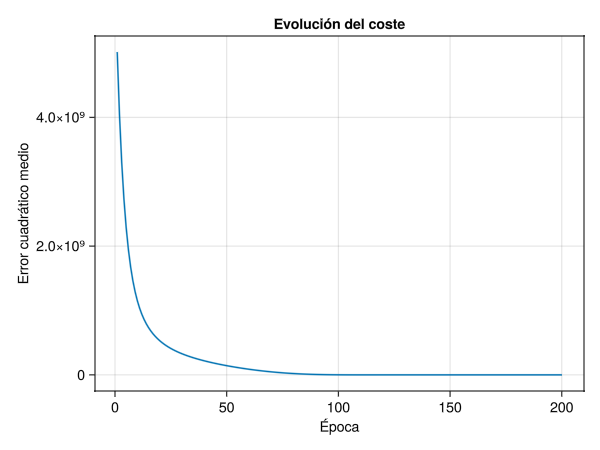

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 831997.2
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32

[1.662782;;]
Pesos del estado de la red neuronal:Float32[-0.04483252;;]


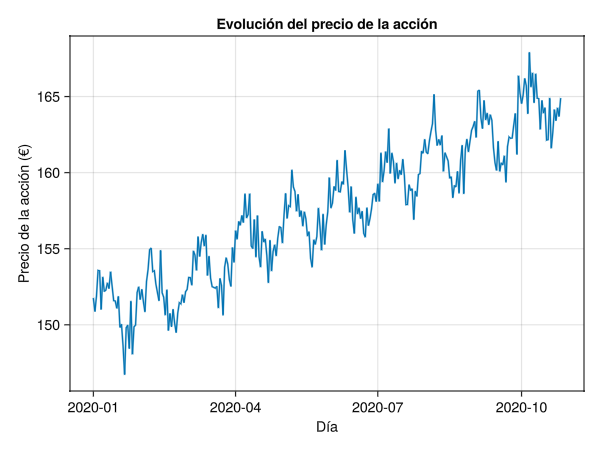

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(LSTMCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
# Semilla aletoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.30396008; 0.20760956; … ; -0.3597482; 0.34133574;;], weight_hh = Float32[-0.14212814 0.124461874 … 0.15857771 0.433253; -0.60061485 0.6888287 … 0.015557139 -0.02396925; … ; -0.48385316 -0.48944378 … -0.14629243 0.24578184; -0.55123943 0.032821797 … -0.46523014 -0.19028853], bias_ih = Float32[0.13318253, -0.45513135, -0.6837966, -0.2415013, -0.16779709, -0.93341047, -0.53952926, -0.48186514, 0.021176515, -0.30743036  …  0.014446886, -0.5721004, 0.45100343, -0.81614524, 0.1888154, -0.56068116, -0.12510449, -0.13552056, -0.24933764, -0.41411588], bias_hh = Float32[-0.22238044, -0.19898348, -0.37900725, 0.058875185, 0.19690755, -0.46746913, -0.44450238, -0.14716838, 0.0064949556, -0.5069497  …  0.30356094, 0.039919093, -1.2327687, -0.44219512, -0.448552, 0.16528183, -0.64270544, 0.10101542, -0.9258155, -0.1611275]), layer_2 = (weight = Float32[-0.112227805 -0.016874027 … -0.14568834 -0.25773373], bias = Float32[-0.08149266])), (layer_1 = (rng = TaskLocal

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

0.8852518f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 300
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 0.43623096


Época 2 | coste = 0.33103812
Época 3 | coste = 0.24049717
Época 4 | coste = 

0.1680395
Época 5 | coste = 0.13074453
Época 6 | coste = 0.12206635
Época 7 | coste = 0.116651
Época 8 | coste = 0.10684295
Época 9 | coste = 0.08634056


Época 10 | coste = 0.07713061
Época 11 | coste = 0.0757228
Época 12 | coste = 0.07615333
Época 13 | coste = 0.07584581


Época 14 | coste = 0.073663846
Época 15 | coste = 0.071494386
Época 16 | coste = 0.0699738
Época 17 | coste = 0.069123074


Época 18 | coste = 0.0691317
Época 19 | coste = 0.06892987
Época 20 | coste = 0.06787545
Época 21 | coste = 0.06709955


Época 22 | coste = 

0.06689984
Época 23 | coste = 0.06686847
Época 24 | coste = 0.066929355
Época 25 | coste = 0.066410184
Época 26 | coste = 

0.06543841
Época 27 | coste = 0.064985305
Época 28 | coste = 0.06492321
Época 29 | coste = 0.064656556
Época 30 | coste = 0.06435795
Época 31 | coste = 0.06394486
Época 32 | coste = 

0.06339418
Época 33 | coste = 0.06316068
Época 34 | coste = 0.063080795
Época 35 | coste = 0.0627255
Época 36 | coste = 0.062254127
Época 37 | coste = 0.061787084
Época 38 | coste = 

0.0613302
Época 39 | coste = 0.06099433
Época 40 | coste = 0.06055367
Época 41 | coste = 0.060018424
Época 42 | coste = 0.05948545
Época 43 | coste = 0.05892993
Época 44 | coste = 

0.05854484
Época 45 | coste = 0.058254723
Época 46 | coste = 0.057805255
Época 47 | coste = 0.05719639


Época 48 | coste = 

0.056644898
Época 49 | coste = 0.056310143
Época 50 | coste = 0.055885673
Época 51 | coste = 0.055256348
Época 52 | coste = 0.054808907
Época 53 | coste = 0.0544421
Época 54 | coste = 

0.05393043
Época 55 | coste = 0.053435855
Época 56 | coste = 0.053102255
Época 57 | coste = 0.052683655
Época 58 | coste = 0.052197214
Época 59 | coste = 0.05181965
Época 60 | coste = 0.051328696
Época 61 | coste = 0.050915662


Época 62 | coste = 0.050515074
Época 63 | coste = 0.050088692
Época 64 | coste = 0.04968396
Época 65 | coste = 0.049227938
Época 66 | coste = 0.048745345
Época 67 | coste = 0.048401352
Época 68 | coste = 

0.047935985
Época 69 | coste = 0.047497056
Época 70 | coste = 0.047112394
Época 71 | coste = 0.046663146
Época 72 | coste = 0.04624891
Época 73 | coste = 0.04601053
Época 74 | coste = 

0.04678905
Época 75 | coste = 0.04746342
Época 76 | coste = 0.046783816
Época 77 | coste = 0.044164788
Época 78 | coste = 0.04642233
Época 79 | coste = 0.046027426
Época 80 | coste = 

0.043258533
Época 81 | coste = 0.04546033
Época 82 | coste = 0.042431198
Época 83 | coste = 0.044231936
Época 84 | coste = 0.04396938
Época 85 | coste = 0.041624848
Época 86 | coste = 

0.043356463
Época 87 | coste = 0.04129307
Época 88 | coste = 0.041446112
Época 89 | coste = 0.04137673
Época 90 | coste = 0.040148143
Época 91 | coste = 0.04105285
Época 92 | coste = 

0.040208206
Época 93 | coste = 0.03948391
Época 94 | coste = 

0.040380195
Época 95 | coste = 0.038798306
Época 96 | coste = 0.038942143
Época 97 | coste = 0.038968805
Época 98 | coste = 0.037875272
Época 99 | coste = 0.03831691
Época 100 | coste = 

0.03787906
Época 101 | coste = 0.037521333
Época 102 | coste = 0.03861687
Época 103 | coste = 0.03721399
Época 104 | coste = 0.037991308
Época 105 | coste = 0.038323022
Época 106 | coste = 

0.035953313
Época 107 | coste = 0.03750779
Época 108 | coste = 0.037213355
Época 109 | coste = 0.03989725
Época 110 | coste = 0.05213875
Época 111 | coste = 0.04114476
Época 112 | coste = 0.042670205
Época 113 | coste = 0.044034585


Época 114 | coste = 0.04164532
Época 115 | coste = 0.041989
Época 116 | coste = 0.03932039
Época 117 | coste = 0.0400527
Época 118 | coste = 0.04034633
Época 119 | coste = 0.038837712


Época 120 | coste = 0.039150722
Época 121 | coste = 0.03753866
Época 122 | coste = 0.0374557
Época 123 | coste = 0.03670148
Época 124 | coste = 0.03617156
Época 125 | coste = 0.036001183


Época 126 | coste = 0.035316676
Época 127 | coste = 0.035709716
Época 128 | coste = 0.035309188
Época 129 | coste = 0.03520872
Época 130 | coste = 0.034567352
Época 131 | coste = 0.034476273


Época 132 | coste = 0.035069607
Época 133 | coste = 0.03615517
Época 134 | coste = 0.036147445
Época 135 | coste = 0.03553891
Época 136 | coste = 0.033885136
Época 137 | coste = 0.03303521


Época 138 | coste = 0.033398885
Época 139 | coste = 0.03384449
Época 140 | coste = 0.035275783
Época 141 | coste = 0.03605826
Época 142 | coste = 0.034556825
Época 143 | coste = 0.03269337


Época 144 | coste = 0.032783225
Época 145 | coste = 0.033845462
Época 146 | coste = 0.034198876
Época 147 | coste = 0.03234724
Época 148 | coste = 0.03181867
Época 149 | coste = 0.03253302


Época 150 | coste = 0.033015415
Época 151 | coste = 0.032146584
Época 152 | coste = 0.031085907
Época 153 | coste = 0.03107505
Época 154 | coste = 0.031566814
Época 155 | coste = 0.03158312


Época 156 | coste = 0.03129263
Época 157 | coste = 0.030610552
Época 158 | coste = 0.029992936
Época 159 | coste = 0.029710393
Época 160 | coste = 0.02945936
Época 161 | coste = 0.029453687


Época 162 | coste = 0.029709501
Época 163 | coste = 0.031259354
Época 164 | coste = 0.03708991
Época 165 | coste = 0.04536164
Época 166 | coste = 0.03205957
Época 167 | coste = 0.035594575


Época 168 | coste = 0.0392568
Época 169 | coste = 0.033047296
Época 170 | coste = 0.038034666
Época 171 | coste = 0.03148449
Época 172 | coste = 0.0353391
Época 173 | coste = 0.03202102


Época 174 | coste = 0.033094373
Época 175 | coste = 0.031869687
Época 176 | coste = 0.03149636
Época 177 | coste = 0.030788377


Época 178 | coste = 

0.030944197
Época 179 | coste = 0.02973847
Época 180 | coste = 0.03048762
Época 181 | coste = 0.029586041
Época 182 | coste = 0.030156406
Época 183 | coste = 0.02827057
Época 184 | coste = 0.029069068
Época 185 | coste = 0.027596166


Época 186 | coste = 0.027933115
Época 187 | coste = 0.027815796
Época 188 | coste = 0.027133942
Época 189 | coste = 0.026608279
Época 190 | coste = 0.027008321
Época 191 | coste = 0.026417397
Época 192 | coste = 

0.026212763
Época 193 | coste = 0.026102174
Época 194 | coste = 0.025798965
Época 195 | coste = 0.026056228
Época 196 | coste = 0.025268944
Época 197 | coste = 0.025329549
Época 198 | coste = 0.025233617
Época 199 | coste = 0.024804207


Época 200 | coste = 0.02483257
Época 201 | coste = 0.024559755
Época 202 | coste = 0.024380462
Época 203 | coste = 0.025029108
Época 204 | coste = 0.024832726
Época 205 | coste = 0.026066849


Época 206 | coste = 0.025572198
Época 207 | coste = 0.025202723
Época 208 | coste = 0.024339253
Época 209 | coste = 0.023903063
Época 210 | coste = 0.02497479
Época 211 | coste = 0.025026882


Época 212 | coste = 0.02390212
Época 213 | coste = 0.024169618
Época 214 | coste = 0.023691678
Época 215 | coste = 0.02480835
Época 216 | coste = 0.024554072
Época 217 | coste = 0.023645394


Época 218 | coste = 0.023716638
Época 219 | coste = 0.022608392
Época 220 | coste = 0.022712471
Época 221 | coste = 0.0226861
Época 222 | coste = 0.021997562
Época 223 | coste = 0.021777777


Época 224 | coste = 0.023093674
Época 225 | coste = 0.024172394
Época 226 | coste = 0.02735256
Época 227 | coste = 0.033267334
Época 228 | coste = 0.03751504
Época 229 | coste = 0.033372913


Época 230 | coste = 0.025727747
Época 231 | coste = 0.030330643
Época 232 | coste = 0.032955572
Época 233 | coste = 0.027605593
Época 234 | coste = 0.027404334
Época 235 | coste = 0.028420568


Época 236 | coste = 0.026068315
Época 237 | coste = 0.024966612
Época 238 | coste = 0.025210736
Época 239 | coste = 0.023920031
Época 240 | coste = 0.02357477
Época 241 | coste = 0.022902407


Época 242 | coste = 0.022585083
Época 243 | coste = 0.02241166
Época 244 | coste = 0.021928478
Época 245 | coste = 0.021564798
Época 246 | coste = 0.021061935
Época 247 | coste = 0.020993449


Época 248 | coste = 0.020799354
Época 249 | coste = 0.020632174
Época 250 | coste = 0.020393815
Época 251 | coste = 0.020049484
Época 252 | coste = 0.019564047
Época 253 | coste = 0.019907514


Época 254 | coste = 0.01966598
Época 255 | coste = 0.021407092
Época 256 | coste = 

0.026592419
Época 257 | coste = 0.022334445
Época 258 | coste = 0.020522296
Época 259 | coste = 0.023001244
Época 260 | coste = 0.022593683
Época 261 | coste = 0.022466991
Época 262 | coste = 0.020802002
Época 263 | coste = 0.019333726


Época 264 | coste = 0.020713102
Época 265 | coste = 0.022634555
Época 266 | coste = 0.027012995
Época 267 | coste = 0.02682226
Época 268 | coste = 0.027546905
Época 269 | coste = 0.028565321
Época 270 | coste = 

0.024567924
Época 271 | coste = 0.024839485
Época 272 | coste = 0.02368475
Época 273 | coste = 0.023752248
Época 274 | coste = 0.022853289
Época 275 | coste = 0.022607004
Época 276 | coste = 0.02121585
Época 277 | coste = 0.020871555


Época 278 | coste = 0.020798242
Época 279 | coste = 0.021295268
Época 280 | coste = 0.01979227
Época 281 | coste = 0.019758949
Época 282 | coste = 0.018773757
Época 283 | coste = 0.018557481
Época 284 | coste = 

0.018755028
Época 285 | coste = 0.018304257
Época 286 | coste = 0.018018387
Época 287 | coste = 0.018036123
Época 288 | coste = 0.017677452
Época 289 | coste = 0.017216362
Época 290 | coste = 

0.017272016
Época 291 | coste = 0.016938856
Época 292 | coste = 0.01687602
Época 293 | coste = 0.017024532
Época 294 | coste = 0.016847618
Época 295 | coste = 0.01721997
Época 296 | coste = 

0.018673766
Época 297 | coste = 0.023966813
Época 298 | coste = 0.020041851
Época 299 | coste = 0.020394666
Época 300 | coste = 0.019673377


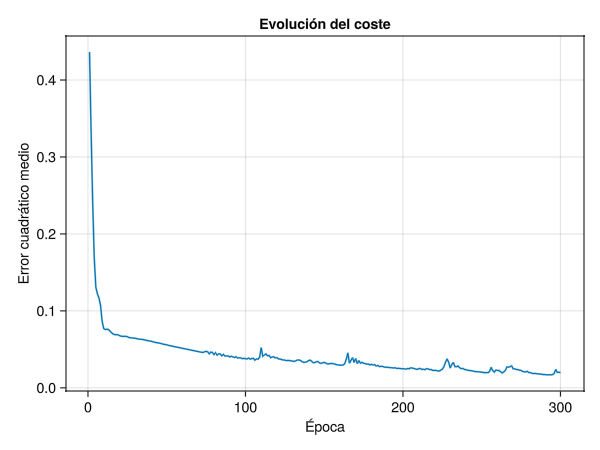

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

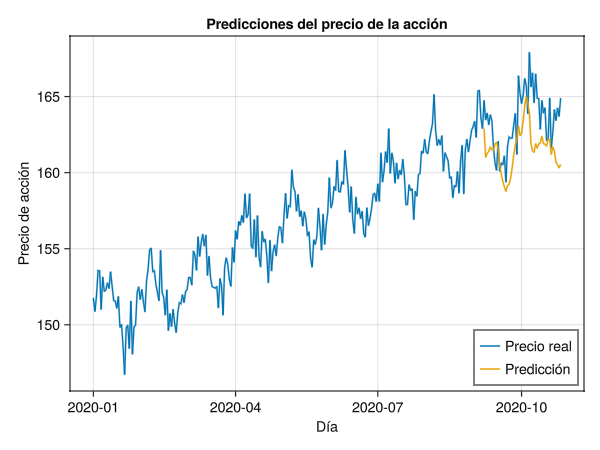

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig